# Kaggle Competition | House Prices - Advanced Regression Techniques
> With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Goal for this Notebook:
Show an example of analysis of the Ames House Price dataset from exploratory data analysis (EDA) to applying ML models in Python.

### This Notebook will show:

### Data Handling and Analysis

- Importing and cleaning data, EDA

### Data Preprocessing

- Imputing values (median, mode), dropping features
- Log transformation of SalePrice to improve feature correlation

### Data Science 

- sklearn Pipelines (ColumnTransformer, model)
- Linear regression models - Basic -> Ridge -> Lasso
- Evaluation methods - K-fold cross-validation to compare model accuracy

### Required Libraries:

- NumPy
- Pandas
- Matplotlib
- Seaborn
- SciKit-Learn

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


### Data Handling
#### First, import the train and test data using pandas:

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(train_data.shape)
train_data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Next, let's get an overview of the SalePrice statistics:

In [3]:
#Get overview of the distribution of sales prices
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The mean is larger than median, suggesting some high SalePrice values skewing the data.

Next, let's look at the types of features in the dataset:

In [4]:

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Linear vs Log of SalePrice
While the model could be trained using the SalePrice directly, there are reasons to consider using the log:

- The prediction accuracy is assessed by taking the root mean squared difference between the LOG of the predicted and observed SalePrice
- The relationship between features to SalePrice is likely to be multiplicative, not additive. E.g. doubling the number of rooms will DOUBLE the price, not add x amount.
- Assuming the data is a random sample, if the data is skewed then this may be evidence of a multiplicative relationship.

We can confirm some of this by visualising a histogram of SalePrice and log(SalePrice):

Skewness: 1.88


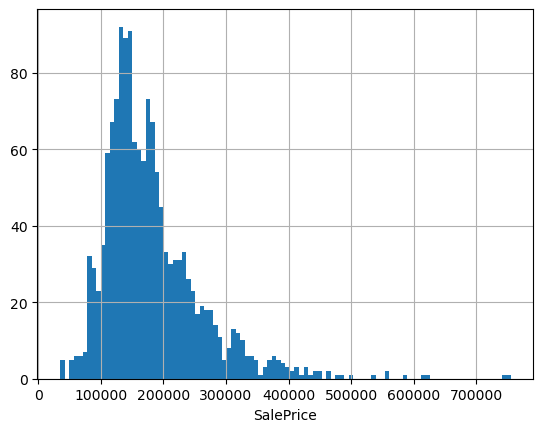

In [5]:
sale_prices = train_data['SalePrice']
sale_prices.hist(bins=100)
plt.xlabel('SalePrice')
print(f'Skewness: {sale_prices.skew():.2f}')

Now let's check the distribution and skewness after taking the log:

Skewness after log: 0.12


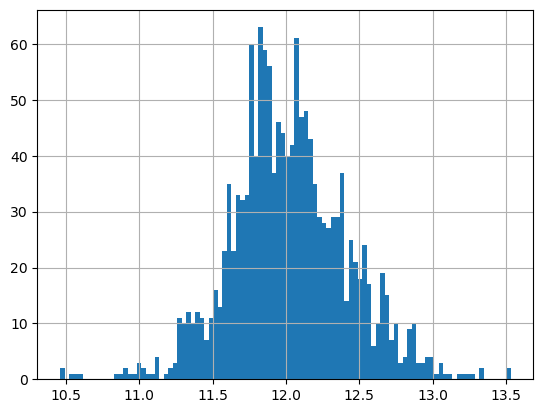

In [6]:
log_sales = np.log(sale_prices)
log_sales.hist(bins=100)
print(f'Skewness after log: {log_sales.skew():.2f}')

Taking the log clearly reduced the skew in the data. It is important to note that this does NOT relate to bringing the residuals (estimated value - reserved value).

A way to establish whether the features correlate to the log(SalePrice) than SalePrice is to calculate their Pearson correlation coefficients and plot to compare:

In [7]:
numerical_cols = train_data.select_dtypes(include=['number'])
log_correlations = numerical_cols.corrwith(log_sales).drop('SalePrice').sort_values(ascending=False)
log_correlations
linear_correlations = numerical_cols.corrwith(sale_prices).drop('SalePrice').sort_values(ascending=False)

corrs = pd.DataFrame({'Log':log_correlations,'Linear':linear_correlations})
corrs = corrs.sort_values('Log',ascending=False).head(20)

Now to plot:

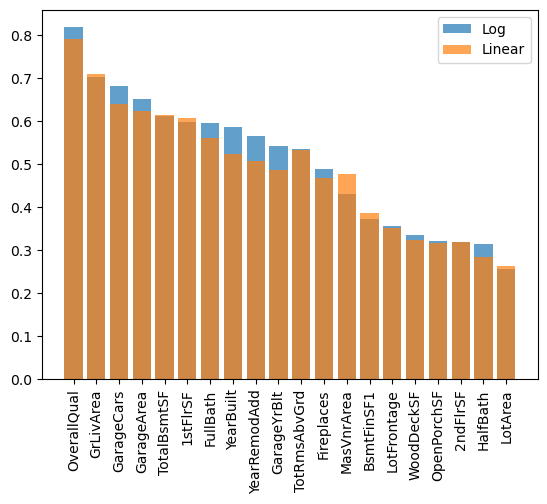

In [8]:
plt.bar(x=corrs.index, height=corrs['Log'],alpha=0.7)
plt.bar(x=corrs.index,height=corrs['Linear'],alpha=0.7)
plt.xticks(rotation=90)
plt.legend(['Log','Linear'])
plt.show()

This shows that, when comparing the numerical features, there is a moderate increase in correlation with log(SalePrice).



In [9]:
#View categorical columns
categorical_cols = train_data.select_dtypes(include=['object'])
categorical_cols.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Given that OverallQual is the most correlated feature, it's worth visualising it:

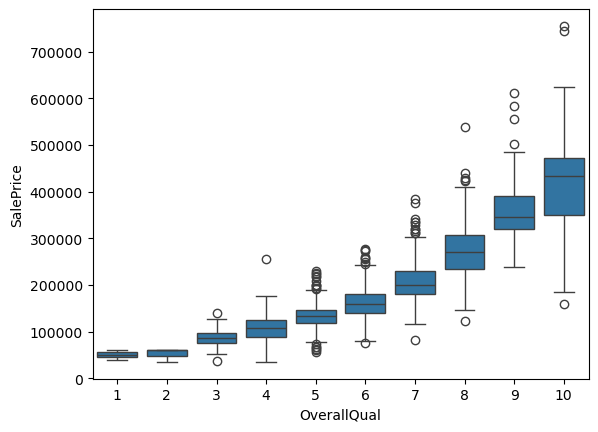

In [10]:
sns.boxplot(data=train_data,x='OverallQual',y='SalePrice')
plt.show()

A categorical value that will likely have a strong correlation is Neighbourhood, so let's visualise this:

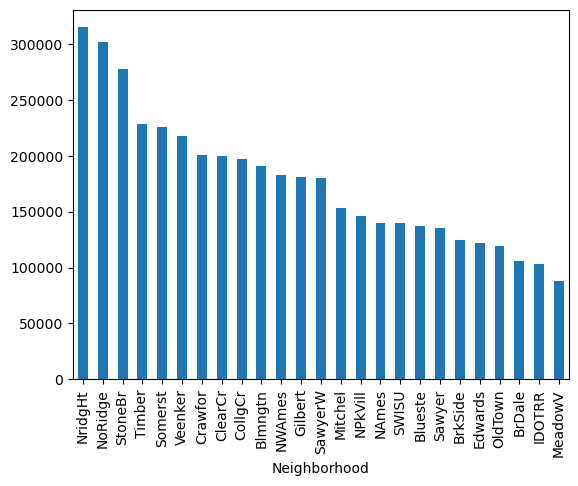

In [11]:
price_neighbourhood = train_data.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending = False)
price_neighbourhood.plot(kind='bar')
plt.show()

### Data Cleaning
The first step is to identify null values in the dataset and how they should be dealt with.

In [12]:
train_data.isna().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

There are two sets of features that are likely related to each other, those relating to Garage and Basement.

First, we should determine if the rows with missing basement values are all aligned, i.e. they likely don't have a Garage and so the values are null.

In [13]:
# Are all of the nulls in the garage columns in the same set of rows?
garage_cols = ['GarageQual','GarageFinish','GarageType','GarageYrBlt','GarageCond']

# Get rows that have any nulls in the garage_cols
garage_nulls = train_data[train_data[garage_cols].isna().any(axis=1)]
print(f' There are {len(garage_nulls)} rows missing one or more garage details') 

 There are 81 rows missing one or more garage details


This shows that all 81 rows are all missing all Garage-related data, so these can be simply set to null.

Next, we can tackle the basement values. The 38 vs 37 rows with null suggest that some rows are only partially missing basement data, so we should explore this:

In [14]:
basement_cols = ['BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtCond','BsmtQual']
basement_nulls = train_data[train_data[basement_cols].isna().any(axis=1)]

# Find rows where not every basement feature is null, only some

basement_nulls[basement_nulls[basement_cols].notna().sum(axis=1) > 0][basement_cols]

,BsmtFinType2,BsmtFinType1,BsmtExposure,BsmtCond,BsmtQual
332,NaN,GLQ,No,TA,Gd
948,Unf,Unf,NaN,TA,Gd


There are only two rows that have incomplete basement data, so these can just be imputed using the mode.

Next, there are a lot of missing LotFrontage values. This is a feature which has a moderate correlation with SalePrice, and so should be investigated carefully. First, we can check if this value generally depends on the other feature, LotConfig:

LotConfig
Inside     134
Corner      62
CulDSac     49
FR2         14
Name: count, dtype: int64


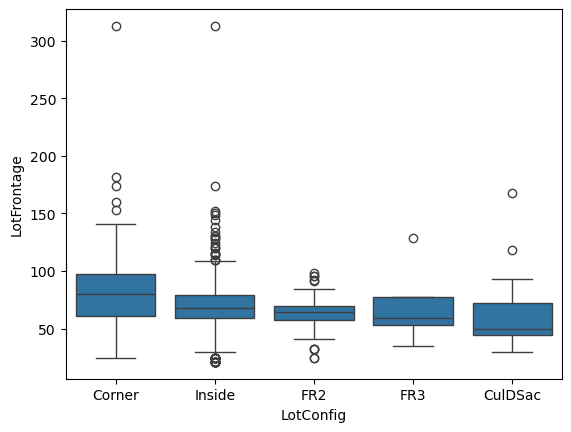

In [15]:
lotconfig_order = train_data.groupby('LotConfig')['LotFrontage'].median().sort_values(ascending=False)

lot_types = train_data[train_data['LotFrontage'].isnull()]['LotConfig'].value_counts()
print(lot_types)
sns.boxplot(x='LotConfig',y='LotFrontage',data=train_data,order=lotconfig_order.index)
plt.show()

There is some correlation, but it is not very strong. Instead, we can check LotFrontage against Neighborhood:

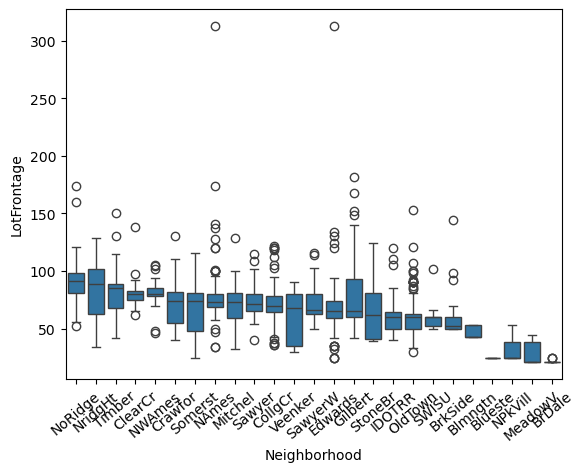

In [16]:
#Order neighbourhoods by median LotFrontage
neighbourhood_order = train_data.groupby('Neighborhood')['LotFrontage'].median().sort_values(ascending=False)

#Plot LotFrontage distribution by neighbourhood
sns.boxplot(x='Neighborhood', y='LotFrontage', data=train_data, order=neighbourhood_order.index)
plt.xticks(rotation=40)
plt.show()

# General correlation, although with some outliers. LotFrontage can be imputed using median of the neighbourhood, or median of the dataset.

There is very clear variation in LotFrontage with Neighborhood. Living in BrDale almost guarantees a low LotFrontage while the opposite is true for NoRidge. This means we can impute LotFrontage based on the median of the neighbourhood.

Next, we can look at the Fireplace and Pool nulls, which are likely are a result of the houses not having a fireplace:

In [17]:
# Check that FireplaceQu nulls are due to no fireplaces
print('Total number of fireplaces in rows that have null FireplaceQu: ', train_data[train_data['FireplaceQu'].isna()]['Fireplaces'].sum())

# Check that PoolQC nulls are due to no pool
print('Total area of pools in rows that have null PoolQC: ', train_data[train_data['PoolQC'].isna()]['PoolArea'].sum())

Total number of fireplaces in rows that have null FireplaceQu:  0
Total area of pools in rows that have null PoolQC:  0


This confirms that these nulls can be replaced with 'NA'.

Next, we can look at Alley nulls. Houses with no alley should have the value NA, according to the data, so we can check if this has been used correctly:

In [18]:
# Check existing values of Alley
train_data['Alley'].value_counts()



Alley
Grvl    50
Pave    41
Name: count, dtype: int64

This confirms that null Alley values can be replaced with NA.

Some houses are missing a MasVnrType, but we should check if they have any MasVnrArea:

In [19]:
# Check if all houses missing MasVnrType have zero MasVnrArea
missing_mas = train_data[train_data['MasVnrType'].isna()]['MasVnrArea'].sort_values(ascending=False)
print(missing_mas.head(10))
print(missing_mas.shape)

1300    344.0
1334    312.0
624     288.0
1230      1.0
773       1.0
989       0.0
974       0.0
975       0.0
976       0.0
978       0.0
Name: MasVnrArea, dtype: float64
(872,)


Some rows do have masonry veneer area even when type is NA, but majority don't. MasVnrType nulls will be replaced with NA.

# EDA Summary
1. SalesPrice is right-skewed - fixed by using log(SalesPrice)
2. SalesPrice generally correlates with quality and size of the house, as well as the garage.
3. The SalesPrice is also very dependent on Neighborhood

# Preprocessing
1. Drop 'Id','MiscFeature' column
2. Impute categorical columns with 'NA' when missing values
3. Impute LotFrontage with median LotFrontage of the Neighborhood, or the median of the dataset

In [20]:
def preprocess_data(df):
    df = df.copy()

    # Columns which will have null replaced with 'NA'
    none_cols = ['BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtCond','BsmtQual',\
                 'GarageQual','GarageFinish','GarageType','GarageCond', 'Alley',\
                 'Fence','MasVnrType','PoolQC','FireplaceQu']

    # Columns which will have null replaced with the mode
    mode_cols = ['Electrical','MSZoning','Utilities','Functional','SaleType','Exterior1st','Exterior2nd','KitchenQual']

    # Columns which will have null replaced with integer 0
    zero_cols = ['GarageYrBlt','MasVnrArea','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtHalfBath',\
                 'TotalBsmtSF','BsmtFullBath','BsmtUnfSF',]

    # Columns that will be dropped
    drop_columns = ['Id','MiscFeature','SalePrice']
    
    for col in none_cols:
        df[col] = df[col].fillna('NA')

    for col in mode_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    for col in zero_cols:
        df[col] = df[col].fillna(0)

    # Group data by neighbourhood and calculate median
    grouped_medians = df.groupby('Neighborhood')['LotFrontage'].median()
    # Assign LotFrontage as median of the neighbourhood
    df['LotFrontage'] = df['LotFrontage'].fillna(df['Neighborhood'].map(grouped_medians))
    # Assign any remaining null values as overall median, if the neighhbourhood is not in the training set
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

    if 'SalePrice' in df.columns:
        df['logSalePrice'] = np.log(df['SalePrice'])
    df.drop(drop_columns,axis=1,inplace=True,errors='ignore')

    return df

train_preprocessed = preprocess_data(train_data)
test_preprocessed = preprocess_data(test_data)
print('Missing values in training set:', train_preprocessed.isna().sum().sum())
print('Missing values in test set:', test_preprocessed.isna().sum().sum())


Missing values in training set: 0
Missing values in test set: 0


In [21]:
def number_of_features(df):
    cat_columns = pd.get_dummies(df.select_dtypes(include=['object'])).shape[1]
    int_columns = df.select_dtypes(include='number').shape[1]
    return cat_columns + int_columns

# Will the training data and testing data have the same number of columns after one hot encoding?
print(number_of_features(train_preprocessed))
print(number_of_features(test_preprocessed))

298
280


Since the training set and test set have a different number of columns, the OneHotEncoder will have to ignore unknowns to allow the fitted model to predict on the test set.

# Linear Regression

We'll compare three linear regression approaches:
1. **Ordinary Least Squares (OLS)** - baseline model
2. **Ridge Regression** - L2 regularisation to reduce overfitting
3. **Lasso Regression** - L1 regularisation for feature selection

All models use 5-fold cross-validation to estimate generalisation performance.

In [22]:
# Import sklearn packages
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Define a function that takes a series of scores and returns the mean
def rmse_score(scores):
        return np.mean(np.sqrt(np.abs(scores)))

X_train = train_preprocessed.drop('logSalePrice',axis=1,errors='ignore')
Y_train = train_preprocessed['logSalePrice']

# Define num/obj columns to handle separately in processing
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(),num_cols), # Normalize numerical features to fit gaussian with mean = 0
        ('cat', OneHotEncoder(handle_unknown='ignore'),cat_cols) # turn categorical variables into 0 or 1
    ]
)



### Basic Linear Regression:

In [23]:
pipeline_ols = Pipeline([
    ('preprocessor',preprocessor),
    ('model',LinearRegression())
])



ols_prediction = abs(cross_val_score(pipeline_ols, X_train, Y_train, cv=5, scoring='neg_mean_squared_error'))
ols_score = rmse_score(ols_prediction)
print(f'Score for OLS Linear Regression: {ols_score:.5f}')

Score for OLS Linear Regression: 0.15568


### Ridge Linear Regression:

In [24]:
from sklearn.linear_model import RidgeCV, LassoCV

# Create pipeline for RidgeCV, a version of Ridge that performs hyperparameter tuning (alpha)

pipeline_ridge = Pipeline([
    ('preprocessor',preprocessor),
    ('model',RidgeCV())
])

# Fit the pipeline to data and check the alpha value

pipeline_ridge.fit(X_train,Y_train)
print(pipeline_ridge.named_steps['model'].alpha_)

ridge_prediction = abs(cross_val_score(pipeline_ridge,X_train,Y_train,cv=5,scoring='neg_mean_squared_error'))
ridge_score = rmse_score(ridge_prediction)

print(f'Score for Ridge Linear Regression: {ridge_score}')

10.0
Score for Ridge Linear Regression: 0.1398270936795023


### Lasso Linear Regression:

In [25]:
# Create pipeline for LassoCV and fit

pipeline_lasso = Pipeline([
    ('preprocessor',preprocessor),
    ('model',LassoCV(max_iter=10000))
])

pipeline_lasso.fit(X_train,Y_train)

# Examine the coefficients fitted by LassoCV

coeffs = pipeline_lasso.named_steps['model'].coef_
print(f'Coefficients kept: {(coeffs != 0).sum()}, coefficients set to zero: {(coeffs == 0).sum()}')

Coefficients kept: 109, coefficients set to zero: 188


In [26]:
lasso_prediction = abs(cross_val_score(pipeline_lasso,X_train,Y_train,cv=5,scoring='neg_mean_squared_error'))
lasso_score = rmse_score(lasso_prediction)

print(f'Score for Lasso Linear Regression: {lasso_score}')

Score for Lasso Linear Regression: 0.13834087783898924


In [27]:
results = pd.DataFrame({
    'Model':['OLS Regression','Ridge Regression','Lasso Regression'],
    'Score': [ols_score,ridge_score,lasso_score]
}).sort_values('Score',ascending=True)

print(results)

              Model     Score
2  Lasso Regression  0.138341
1  Ridge Regression  0.139827
0    OLS Regression  0.155677


## Conclusion
Lasso gave the lowest root mean squared error of the log of SalePrice, so we can generate our submission.csv using this:

In [28]:
pipeline_lasso.fit(X_train,Y_train)

X_test = test_preprocessed

log_predictions_lasso = pipeline_lasso.predict(X_test)
predictions_final = np.exp(log_predictions_lasso)
output = pd.DataFrame({'Id':test_data['Id'],'SalePrice':predictions_final})

output.to_csv('submission.csv',index=False)
output.head()

,Id,SalePrice
0,1461,116515.466287
1,1462,145369.290760
2,1463,172510.921589
3,1464,199330.870154
4,1465,195974.596028


### Final Scores
OLS Linear Regression: 0.15738
Lasso Regression: 0.13283